In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from umap import UMAP
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS, ClassicalMDS
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

from cove import COVE
from cove.dimension_reduction import LaplacianEigenmap, UMAPLE
from utils import *

# Various warnings make progress bar messy. Comment out for bug fixing
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Run link prediction experiment
def hadamard(v1, v2):
    return v1 * v2

def euclidean(v1, v2):
    return (v1 - v2)**2

In [11]:
def make_test_set(adjacency, test_prop=0.05, rng=None):
    edges = sp.triu(adjacency).nonzero()
    if rng is None:
        rng = np.random.default_rng()
    test_size = int(test_prop*len(edges[0]))
    test_edge_ids = rng.choice(len(edges[0]), size=test_size, replace=False)
    partial_adjacency = adjacency.copy()
    for eid in test_edge_ids:
        partial_adjacency[edges[0][eid], edges[1][eid]] = 0
        partial_adjacency[edges[1][eid], edges[0][eid]] = 0
    partial_adjacency.eliminate_zeros()
    return edges, test_edge_ids, partial_adjacency


def link_pred_scores(adjacency, partial_adjacency, edges, test_edge_ids, embedding, sim=hadamard, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    ## Build Training Data
    training_data = []
    training_labels = []
    # Positive Samples
    for n1, n2 in zip(*sp.triu(partial_adjacency).nonzero()):
        training_data.append(sim(embedding[n1, :], embedding[n2, :]))
    n_samples = len(training_data)
    training_labels = [1]*n_samples
    # Negative Samples
    samples = [tuple(rng.choice(partial_adjacency.shape[0], size=2, replace=False)) for _ in range(n_samples*2)]
    samples = [(min(sample), max(sample)) for sample in samples if partial_adjacency[sample[0], sample[1]] == 0]
    samples = list(set(samples))
    if len(samples) < n_samples:
        raise Exception("Did not find enough negative samples.")
    for n1, n2 in samples[:n_samples]:
        training_data.append(sim(embedding[n1, :], embedding[n2, :]))
    training_labels.extend([0]*n_samples)

    ## train model
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(training_data, training_labels)

    # Build Test data
    test_data = []
    test_labels = []
    # Test positives
    for eid in test_edge_ids:
        test_data.append(sim(embedding[edges[0][eid], :], embedding[edges[1][eid], :]))
    n_samples = len(test_data)
    # Test negatives
    samples = [tuple(rng.choice(adjacency.shape[0], size=2, replace=False)) for _ in range(n_samples*2)]
    samples = [(min(sample), max(sample)) for sample in samples if adjacency[sample[0], sample[1]] == 0]
    samples = list(set(samples))[:n_samples]
    for n1, n2 in samples:
        test_data.append(sim(embedding[n1, :], embedding[n2, :]))
    # Labels
    test_labels = np.zeros(2*n_samples, dtype="bool")
    test_labels[:n_samples] = True

    pred = logreg.predict(test_data).astype("bool")
    fs = np.sum(test_labels*pred) / np.sum(test_labels+pred)
    acc = logreg.score(test_data, test_labels)
    auc = roc_auc_score(test_labels, logreg.predict_proba(test_data)[:,1])

    return fs, acc, auc

In [14]:
graphs = ["football", "primary1", "primary2", "eu-core", "eurosis", "cora_small", "airport", "blogcatalog", "cora", "as"]
data = []
RUNS=10
dims=16
rng = np.random.default_rng(seed=42)

n_walks = 10
walk_len = 40
window_size = 7

cove = COVE(walks_per_node=n_walks, walk_length=walk_len, window_length=window_size)
umap = UMAP(n_components=dims, metric="euclidean")
umaple = UMAPLE(dimension=dims, metric="euclidean")
svd = TruncatedSVD(n_components=dims)

for graph in graphs:
    print(graph)
    adj, lab = load_graph(graph)
    for run in trange(RUNS):
        edges, test, part = make_test_set(adj, rng=rng)

        print("COVE")
        high = cove.fit_transform(part)

        print("UMAP")
        low = umap.fit_transform(high)
        while np.any(np.isnan(low)):
            low = umap.fit_transform(high)
        fs, acc, auc = link_pred_scores(adj, part, edges, test, low, rng=rng)
        data.append({"graph":graph, "method":"COVE+UMAP", "run":run, "F*":fs, "ACC":acc, "AUC":auc})

        print("UMAPLE")
        low = umaple.fit_transform(high, part)
        while np.any(np.isnan(low)):
            low = umaple.fit_transform(high)
        fs, acc, auc = link_pred_scores(adj, part, edges, test, low, rng=rng)
        data.append({"graph":graph, "method":"COVE+UMAPLE", "run":run, "F*":fs, "ACC":acc, "AUC":auc})

        print("SVD")
        low = svd.fit_transform(high)
        fs, acc, auc = link_pred_scores(adj, part, edges, test, low, rng=rng)
        data.append({"graph":graph, "method":"COVE+SVD", "run":run, "F*":fs, "ACC":acc, "AUC":auc})

        print("N2V")
        low = node2vec(part, dims, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
        fs, acc, auc = link_pred_scores(adj, part, edges, test, low, rng=rng)
        data.append({"graph":graph, "method":"N2V", "run":run, "F*":fs, "ACC":acc, "AUC":auc})

        print("N2V + UMAP")
        high = node2vec(part, 128, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
        low = UMAP(metric="cosine").fit_transform(high)
        while np.any(np.isnan(low)):
            low = UMAP(metric="cosine").fit_transform(high)
        fs, acc, auc = link_pred_scores(adj, part, edges, test, low, rng=rng)
        data.append({"graph":graph, "method":"N2V+UMAP", "run":run, "F*":fs, "ACC":acc, "AUC":auc})
df = pd.DataFrame(data)
df.to_pickle(f"link_pred_dim{dims}.pkl")

football


  0%|          | 0/3 [00:00<?, ?it/s]

COVE
UMAP
UMAPLE


 33%|███▎      | 1/3 [00:00<00:00,  2.12it/s]

COVE
UMAP
UMAPLE


 67%|██████▋   | 2/3 [00:00<00:00,  2.25it/s]

COVE
UMAP
UMAPLE


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


primary1


  0%|          | 0/3 [00:00<?, ?it/s]

COVE
UMAP
UMAPLE


 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

COVE
UMAP
UMAPLE


 67%|██████▋   | 2/3 [00:03<00:01,  1.92s/it]

COVE
UMAP
UMAPLE


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


primary2


  0%|          | 0/3 [00:00<?, ?it/s]

COVE
UMAP
UMAPLE


 33%|███▎      | 1/3 [00:02<00:04,  2.16s/it]

COVE
UMAP
UMAPLE


 67%|██████▋   | 2/3 [00:04<00:02,  2.06s/it]

COVE
UMAP
UMAPLE


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


eu-core


  0%|          | 0/3 [00:00<?, ?it/s]

COVE
UMAP
UMAPLE


 33%|███▎      | 1/3 [00:17<00:35, 17.60s/it]

COVE
UMAP
UMAPLE


 67%|██████▋   | 2/3 [00:35<00:17, 17.67s/it]

COVE
UMAP
UMAPLE


100%|██████████| 3/3 [00:51<00:00, 17.24s/it]


eurosis


  0%|          | 0/3 [00:00<?, ?it/s]

COVE
UMAP
UMAPLE


 33%|███▎      | 1/3 [00:23<00:47, 23.62s/it]

COVE
UMAP
UMAPLE


 67%|██████▋   | 2/3 [00:47<00:23, 23.78s/it]

COVE
UMAP
UMAPLE


100%|██████████| 3/3 [01:11<00:00, 23.98s/it]


In [4]:
df = pd.read_pickle(f"link_pred_dim16.pkl")
#df = pd.DataFrame(data)
df

,graph,method,run,F*,ACC,AUC
0,football,COVE+UMAP,0,0.764706,0.866667,0.921111
1,football,COVE+UMAPLE,0,0.710526,0.816667,0.902222
2,football,COVE+SVD,0,0.764706,0.866667,0.950000
3,football,N2V,0,0.742857,0.850000,0.953333
4,football,N2V+UMAP,0,0.722222,0.833333,0.905556
...,...,...,...,...,...,...
495,as,COVE+UMAP,9,0.614494,0.754966,0.837420
496,as,COVE+UMAPLE,9,0.610778,0.755137,0.833866
497,as,COVE+SVD,9,0.524561,0.638699,0.714852
498,as,N2V,9,0.507927,0.723630,0.830040


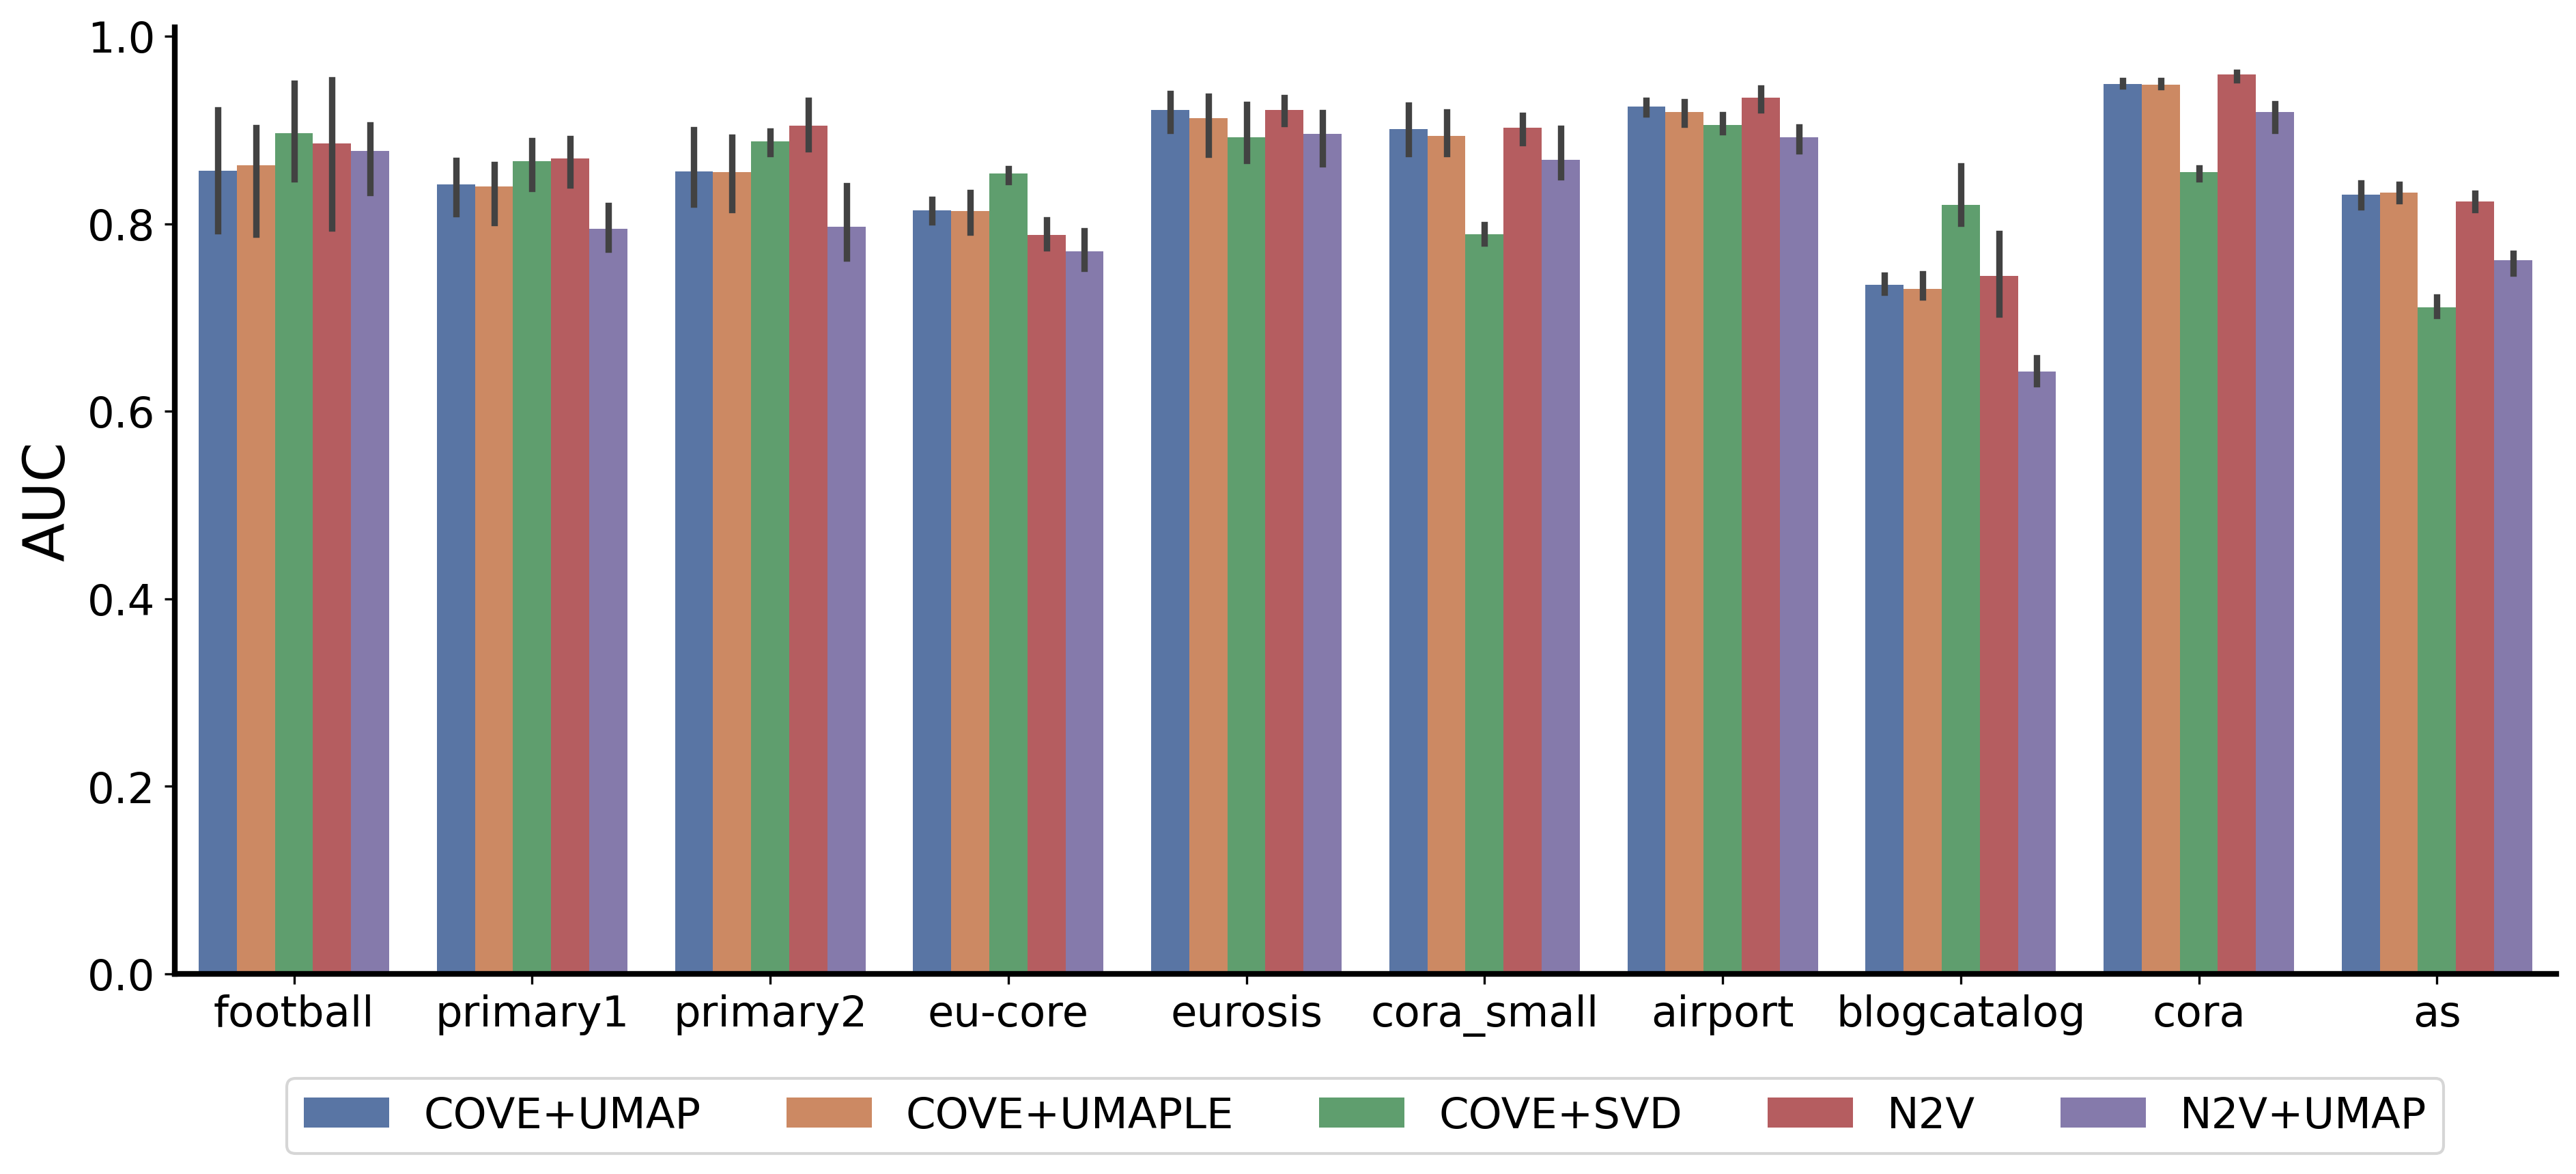

In [5]:
fig, ax = plt.subplots(figsize=(15,6), dpi=300)
sns.barplot(df, x="graph", y="AUC", hue="method", ax=ax, palette="deep", errorbar=("pi", 100))
ax.set_ylabel("AUC", fontsize=20)

for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.legend(
    bbox_to_anchor=[0.5, -0.15], 
    loc='center',
    ncols=5,
    fancybox=True,
    fontsize=15,
)